In [1]:
%cd ..

/Users/udeepa/Documents/UCL/Term 2/numerical/svm


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

from sklearn.metrics import confusion_matrix, classification_report

from opt.svm import SVC
from opt.utils.data_splitter import split4ovr, split4ovo
from opt.utils.metrics import measure_performance

# Fix random seed
np.random.seed(0)

### Dataset

In [3]:
# Load data
# data = np.load('data/dummy_binary/filtered_mnist.npz')
data = np.load('data/filtered_mnist.npz')
x_train = data['a']
y_train = data['b']
x_test  = data['c']
y_test  = data['d']
print("Number of training samples:       ", len(y_train))
print("Distribution of training samples: ", Counter(y_train))
print("Number of test samples:           ", len(y_test))
print("Distribution of training samples: ", Counter(y_test))

Number of training samples:        2000
Distribution of training samples:  Counter({6: 500, 0: 500, 9: 500, 1: 500})
Number of test samples:            800
Distribution of training samples:  Counter({6: 200, 9: 200, 0: 200, 1: 200})


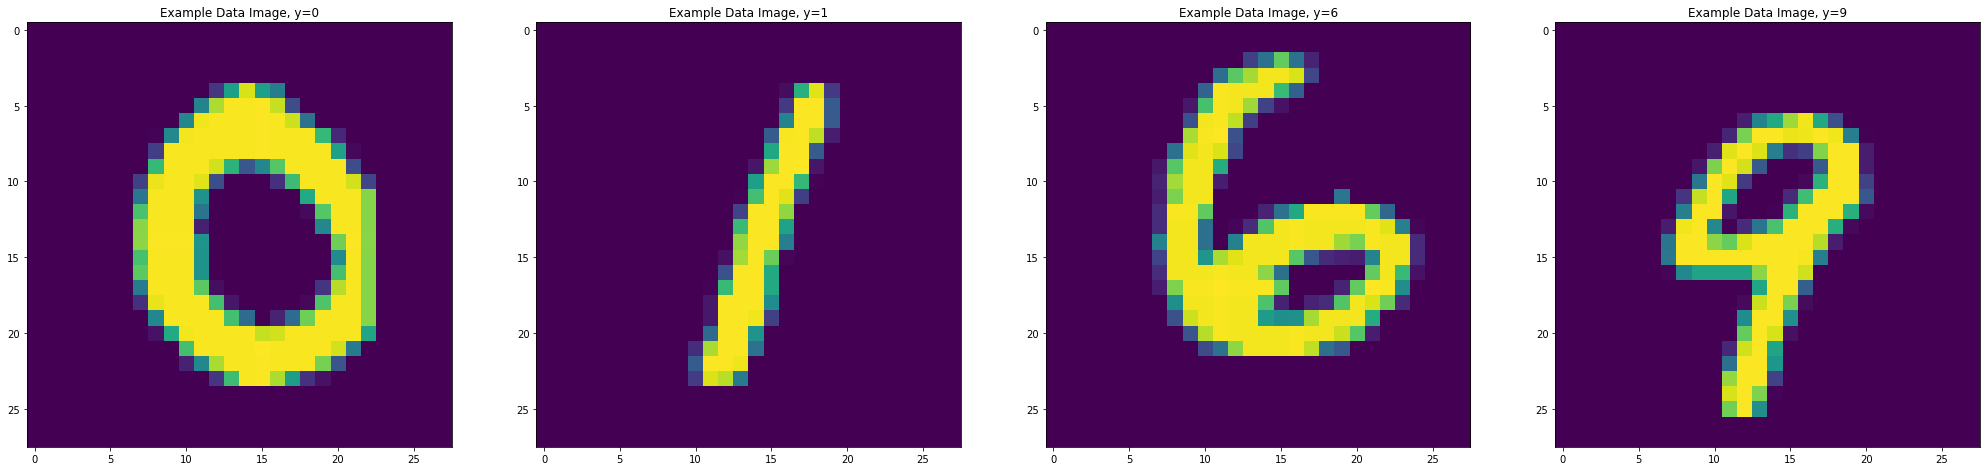

In [4]:
# Visualise data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(35,35))
imx, imy = (28,28)
visual = np.reshape(x_train[2], (imx,imy))
ax1.set_title("Example Data Image, y="+str(int(y_train[2])))
ax1.imshow(visual, vmin=0, vmax=1)
visual = np.reshape(x_train[36], (imx,imy))
ax2.set_title("Example Data Image, y="+str(int(y_train[36])))
ax2.imshow(visual, vmin=0, vmax=1)
visual = np.reshape(x_train[10], (imx,imy))
ax3.set_title("Example Data Image, y="+str(int(y_train[10])))
ax3.imshow(visual, vmin=0, vmax=1)
visual = np.reshape(x_train[8], (imx,imy))
ax4.set_title("Example Data Image, y="+str(int(y_train[8])))
ax4.imshow(visual, vmin=0, vmax=1)

## Main

#### Scikit-Learn SVM

In [5]:
from sklearn.svm import SVC as cheatSVM
cheat_svm = cheatSVM(C=1.0,
                     kernel='rbf',
                     decision_function_shape='ovo') 
cheat_svm.fit(x_train, y_train)
cheat_pred = cheat_svm.predict(x_test)

In [6]:
measure_performance(y_test, cheat_pred, average="macro")

,Accuracy,Precision,Recall,F1,MCC
0,0.9912,0.9913,0.9912,0.9912,0.9884


#### My SVM

Problems:
1. For Barrier, the point $\mathbf{x}_k$ after Newton is not feasible, thus why the log barrier function spits out a nan

In [7]:
# OVR data: y_train_ovr = split4ovr(y_train)
# Train OVR: svm.fit(x_train, y_train_ovr)

In [8]:
# OVO data
x_train_ovo, y_train_ovo = split4ovo(x_train, y_train)

In [9]:
# Parameters
# Initialise SVM
L1_svm = SVC(C=1.0, 
              kernel="gauss", 
              param='scale', 
              decision_function_shape="ovo",
              loss_fn='L1',
              opt_algo="smo")


# L1_svm.fit(x_train_ovo, y_train_ovo,
#             t=1, 
#             mu=20, 
#             tol=1e-6, 
#             max_iter=100,
#             tolNewton=1e-12,
#             maxIterNewton=100)

L1_svm.fit(x_train_ovo, y_train_ovo,
        tol=1e-3, 
        max_iter=5)

# Test
L1_yhat = L1_svm.predict(x_test)
print("Time taken: ", L1_svm.time_taken)
measure_performance(y_test, L1_yhat, average="macro")

SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
Time taken:  1.593837


,Accuracy,Precision,Recall,F1,MCC
0,0.9812,0.9814,0.9812,0.9813,0.975


In [10]:
L2_svm = SVC(C=1.0, 
          kernel="gauss", 
          param='scale', 
          decision_function_shape="ovo",
          loss_fn='L2',
          opt_algo="smo")

# L2_svm.fit(x_train_ovo, y_train_ovo,
#         t=1, 
#         mu=20, 
#         tol=1e-6, 
#         max_iter=100,
#         tolNewton=1e-12,
#         maxIterNewton=100)

L2_svm.fit(x_train_ovo, y_train_ovo,
        tol=1e-3, 
        max_iter=100)

# Test
L2_yhat = L2_svm.predict(x_test)
print("Time taken: ", L2_svm.time_taken)
measure_performance(y_test, L2_yhat, average="macro")

SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
SMO method iteration:  5
SMO method iteration:  6
SMO method iteration:  7
SMO method iteration:  8
SMO method iteration:  9
SMO method iteration:  10
SMO method iteration:  11
SMO method iteration:  12
SMO method iteration:  13
SMO method iteration:  14
SMO method iteration:  15
SMO method iteration:  16
SMO method iteration:  17
SMO method iteration:  18
SMO method iteration:  19
SMO method iteration:  20
SMO method iteration:  21
SMO method iteration:  22
SMO method iteration:  23
SMO method iteration:  24
SMO method iteration:  25
SMO method iteration:  26
SMO method iteration:  27
SMO method iteration:  28
SMO method iteration:  29
SMO method iteration:  30
SMO method iteration:  31
SMO method iteration:  32
SMO method iteration:  33
SMO method iteration:  34
SMO method iteration:  35
SMO method iteration:  36
SMO method iteration:  37
SMO method iteration: 

SMO method iteration:  20
SMO method iteration:  21
SMO method iteration:  22
SMO method iteration:  23
SMO method iteration:  24
SMO method iteration:  25
SMO method iteration:  26
SMO method iteration:  27
SMO method iteration:  28
SMO method iteration:  29
SMO method iteration:  30
SMO method iteration:  31
SMO method iteration:  32
SMO method iteration:  33
SMO method iteration:  34
SMO method iteration:  35
SMO method iteration:  36
SMO method iteration:  37
SMO method iteration:  38
SMO method iteration:  39
SMO method iteration:  40
SMO method iteration:  41
SMO method iteration:  42
SMO method iteration:  43
SMO method iteration:  44
SMO method iteration:  45
SMO method iteration:  46
SMO method iteration:  47
SMO method iteration:  48
SMO method iteration:  49
SMO method iteration:  50
SMO method iteration:  51
SMO method iteration:  52
SMO method iteration:  53
SMO method iteration:  54
SMO method iteration:  55
SMO method iteration:  56
SMO method iteration:  57
SMO method i

,Accuracy,Precision,Recall,F1,MCC
0,0.9912,0.9913,0.9912,0.9912,0.9884


#### Convergence Plots

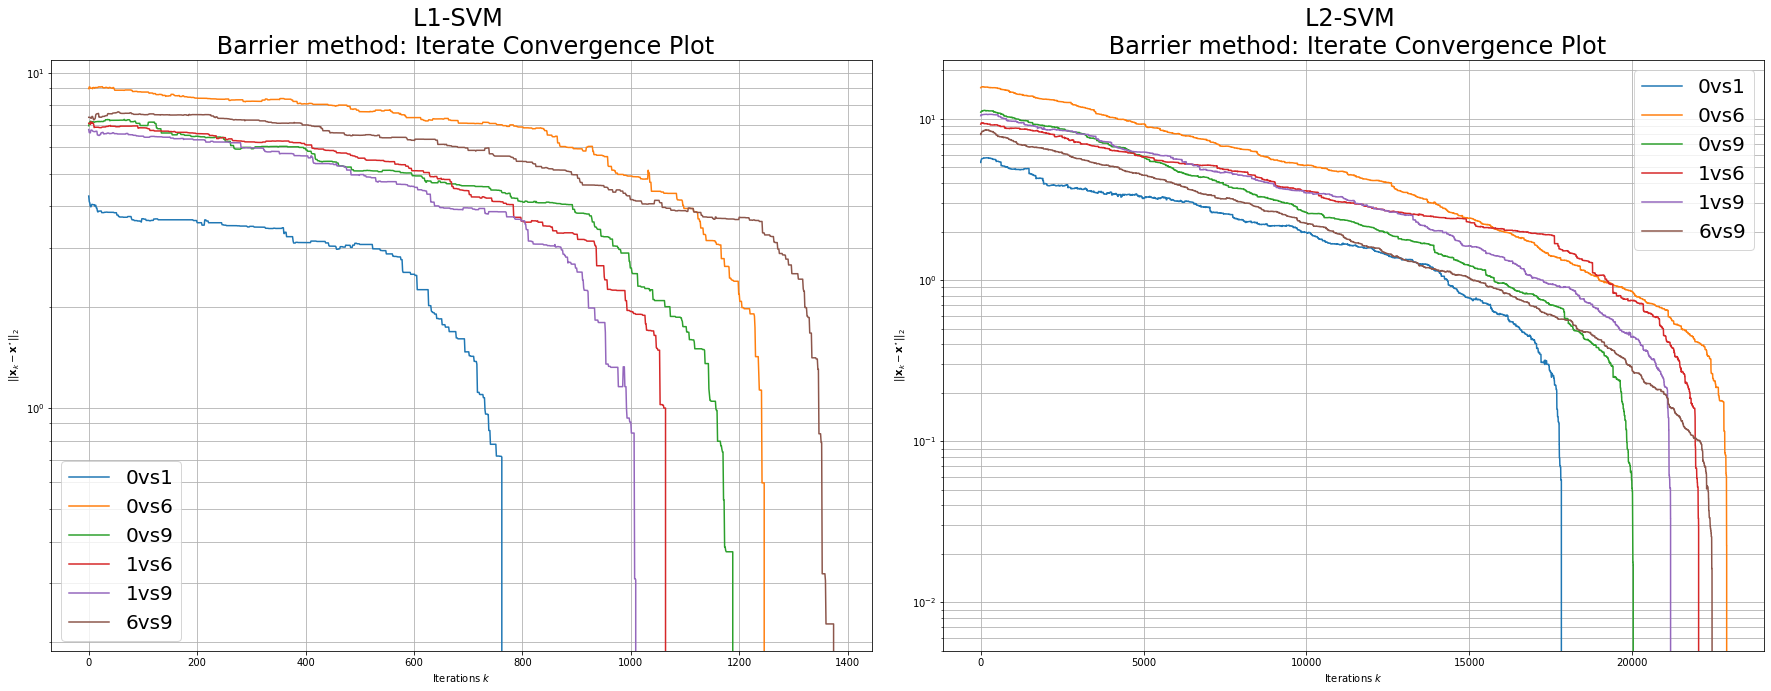

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,10))
plt.rcParams.update({'font.size': 20})

for ClassVsClass, info in L1_svm.opt_info.items():
    ax1.plot(np.linalg.norm(np.array(info['iterates'])-info['x'], axis=1), label=ClassVsClass)
ax1.set_title("L1-SVM \n Barrier method: Iterate Convergence Plot")
ax1.set_ylabel("$|| \mathbf{x}_k-\mathbf{x}^{\star} ||_2$")
ax1.set_xlabel("Iterations $k$")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(which='both', axis='both') 
    
for ClassVsClass, info in L2_svm.opt_info.items():
    ax2.plot(np.linalg.norm(np.array(info['iterates'])-info['x'], axis=1), label=ClassVsClass)
plt.title("L2-SVM \n Barrier method: Iterate Convergence Plot")
plt.ylabel("$|| \mathbf{x}_k-\mathbf{x}^{\star} ||_2$")
plt.xlabel("Iterations $k$")
plt.yscale("log")
plt.legend()
plt.grid(which='both', axis='both')
plt.tight_layout()
# plt.savefig("docs/report_pics/smo_iterate_conv.pdf", format="pdf")
plt.show()

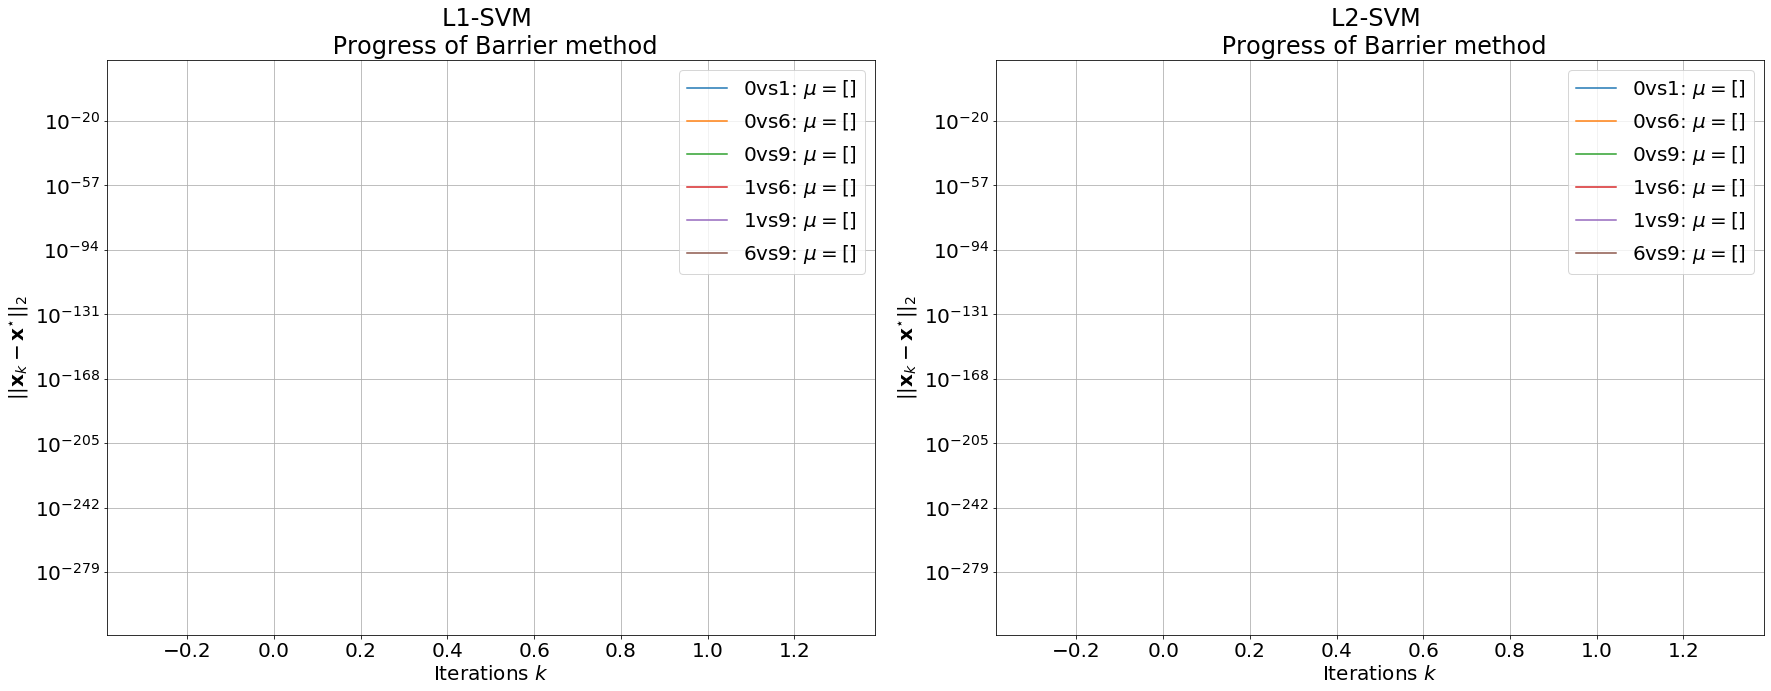

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,10))
plt.rcParams.update({'font.size': 20})

for ClassVsClass, info in L1_svm.opt_info.items():
    ax1.step(np.cumsum(info['newton_iterations']), info['duality_gaps'], 
             label=str(ClassVsClass)+": $\mu=$"+str(info['mu']))
ax1.set_title("L1-SVM \n Progress of Barrier method")
ax1.set_ylabel("$|| \mathbf{x}_k-\mathbf{x}^{\star} ||_2$")
ax1.set_xlabel("Iterations $k$")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(which='both', axis='both') 
    
for ClassVsClass, info in L2_svm.opt_info.items():
    ax2.step(np.cumsum(info['newton_iterations']), info['duality_gaps'], 
             label=str(ClassVsClass)+": $\mu=$"+str(info['mu']))
plt.title("L2-SVM \n Progress of Barrier method")
plt.ylabel("$|| \mathbf{x}_k-\mathbf{x}^{\star} ||_2$")
plt.xlabel("Iterations $k$")
plt.yscale("log")
plt.legend()
plt.grid(which='both', axis='both')
plt.tight_layout()
# plt.savefig("docs/report_pics/barrier_duality_gap.pdf", format="pdf")
plt.show()

#### Confusion matrix

In [13]:
L1_conf_matrix = confusion_matrix(y_test, L1_yhat, normalize=None)
L2_conf_matrix = confusion_matrix(y_test, L2_yhat, normalize=None)

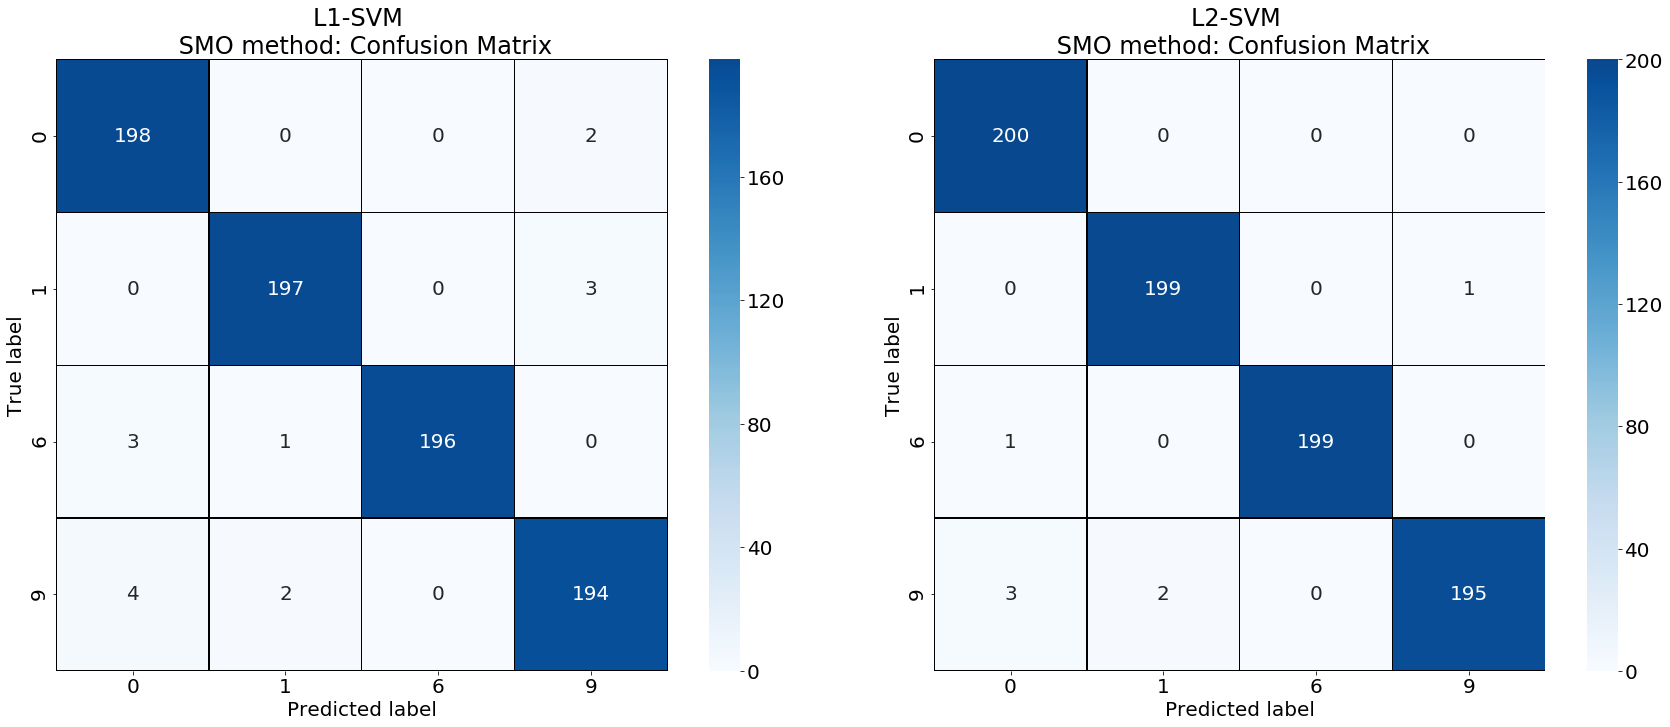

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,10))
plt.rcParams.update({'font.size': 20})
# Plot averaged confusion matrix
df_cm = pd.DataFrame(L1_conf_matrix, 
                     index=np.unique(y_test),
                     columns=np.unique(y_test))
sns.heatmap(df_cm, annot=True, fmt='', cmap='Blues',
            cbar=True, square=True, center=110,
            linewidths=.1, linecolor='black', ax=ax1)
ax1.set_ylim((4,0))
ax1.set_title("L1-SVM \n SMO method: Confusion Matrix")
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')

# Plot averaged confusion matrix
df_cm = pd.DataFrame(L2_conf_matrix, 
                     index=np.unique(y_test),
                     columns=np.unique(y_test))
sns.heatmap(df_cm, annot=True, fmt='', cmap='Blues',
            cbar=True, square=True, center=110,
            linewidths=.1, linecolor='black', ax=ax2)
plt.ylim((4,0))
plt.title("L2-SVM \n SMO method: Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
# plt.savefig("report/report_pics/smo_confusion_matrix.pdf", format="pdf")
plt.show()